In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 707kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 7.67MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.78MB/s]


In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Matplotlib is building the font cache; this may take a moment.


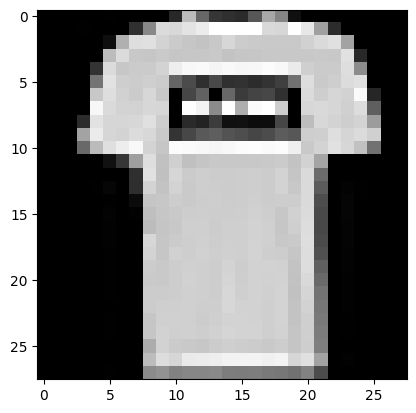

In [5]:
import matplotlib.pyplot as plt

def show_data(data):
    plt.imshow(data[0][0].squeeze(), cmap="gray")
    plt.show()

show_data(training_data[1])

In [6]:
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [21]:
torch.softmax(model(training_data[0][0]), dim= -1)

tensor([[5.5933e-04, 2.4938e-04, 2.8453e-03, 9.6341e-04, 4.1946e-03, 9.1423e-02,
         2.6427e-03, 1.4437e-02, 6.0054e-02, 8.2263e-01]],
       grad_fn=<SoftmaxBackward0>)

In [11]:
# count the number of parameters in the model

print(sum(p.numel() for p in model.parameters()))

7850


In [12]:
out = model(training_data[1][0])
out

tensor([[-0.0753, -0.4569, -0.1910, -0.3754,  0.2837,  0.5087, -0.1128,  0.6296,
         -0.1853, -0.0606]], grad_fn=<AddmmBackward0>)

In [13]:
torch.max(torch.softmax(model(training_data[1][0]), dim=-1), dim=-1)

torch.return_types.max(
values=tensor([0.1769], grad_fn=<MaxBackward0>),
indices=tensor([7]))

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.723707  [   64/60000]
loss: 0.819929  [ 6464/60000]
loss: 0.588266  [12864/60000]
loss: 0.842759  [19264/60000]
loss: 0.699909  [25664/60000]
loss: 0.718782  [32064/60000]
loss: 0.762611  [38464/60000]
loss: 0.743380  [44864/60000]
loss: 0.786267  [51264/60000]
loss: 0.716416  [57664/60000]
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.724460 

Epoch 2
-------------------------------
loss: 0.705670  [   64/60000]
loss: 0.803160  [ 6464/60000]
loss: 0.572656  [12864/60000]
loss: 0.829236  [19264/60000]
loss: 0.688781  [25664/60000]
loss: 0.705416  [32064/60000]
loss: 0.748698  [38464/60000]
loss: 0.734196  [44864/60000]
loss: 0.775353  [51264/60000]
loss: 0.704125  [57664/60000]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.711808 

Epoch 3
-------------------------------
loss: 0.689777  [   64/60000]
loss: 0.788106  [ 6464/60000]
loss: 0.559005  [12864/60000]
loss: 0.817136  [19264/60000]
loss: 0.678932  [25664/60000]
loss: 0.693542  [32064/600

In [25]:
test(train_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.723502 

